In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2024-10-19 19:14:18.459282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 19:14:18.468772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 19:14:18.478282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 19:14:18.481499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 19:14:18.489001: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# load dataset
imsize = 224
image_dir = '../train/'
metadata = pd.read_csv('../train.csv')
metadata['filename'] = metadata['id'].apply(lambda x: f"{image_dir}{x}.jpg")
train_df, val_df = train_test_split(metadata, test_size=0.2, random_state=42)

In [3]:
val_df

,id,shapeset,type,total_height,instability_type,cam_angle,stable_height,filename
5992,788902,2,1,6,1,1,2,../train/788902.jpg
4466,586509,2,1,5,1,1,3,../train/586509.jpg
1575,210276,2,1,6,2,1,3,../train/210276.jpg
4787,633089,2,2,5,2,2,4,../train/633089.jpg
3538,464856,1,2,6,1,2,3,../train/464856.jpg
...,...,...,...,...,...,...,...,...
5259,694978,1,2,3,1,1,2,../train/694978.jpg
1201,158220,2,2,5,1,2,3,../train/158220.jpg
4832,639776,2,2,5,1,2,2,../train/639776.jpg
3768,492635,2,2,4,0,1,4,../train/492635.jpg


In [4]:
# Function to load and preprocess images
def preprocess(filepath, label):
    image = tf.io.read_file(filepath) # load file
    image = tf.image.decode_jpeg(image, channels=3) # decode it into a tensor
    image = tf.image.resize(image, [224, 224])
    image = (image - 127.5) / 127.5
    return image, label - 1

In [5]:
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filename'], val_df['stable_height']))
val_ds = val_ds.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1729325660.853769  645571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729325660.877234  645571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729325660.877302  645571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729325660.879078  645571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729325660.879123  645571 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
ground_truth = val_df['stable_height'] - 1
ground_truth_tensor = tf.convert_to_tensor(ground_truth)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [7]:
resnet_baseline = load_model("../model/resnet50.keras")

In [8]:
predictions = resnet_baseline.predict(val_ds)

I0000 00:00:1729325668.765021  645629 service.cc:146] XLA service 0x7f55c80026f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729325668.765044  645629 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-10-19 19:14:28.806068: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 19:14:29.097400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-19 19:14:29.624571: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1679', 196 bytes spill stores, 196 bytes spill loads



 6/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

I0000 00:00:1729325671.744370  645629 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


In [9]:
loss = loss_function(ground_truth_tensor, predictions)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.1603141>

In [10]:
# Calculate accuracy
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
accuracy.update_state(ground_truth_tensor, predictions)
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5520833>

In [11]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(predictions, axis=1)


2024-10-19 19:14:33.574758: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


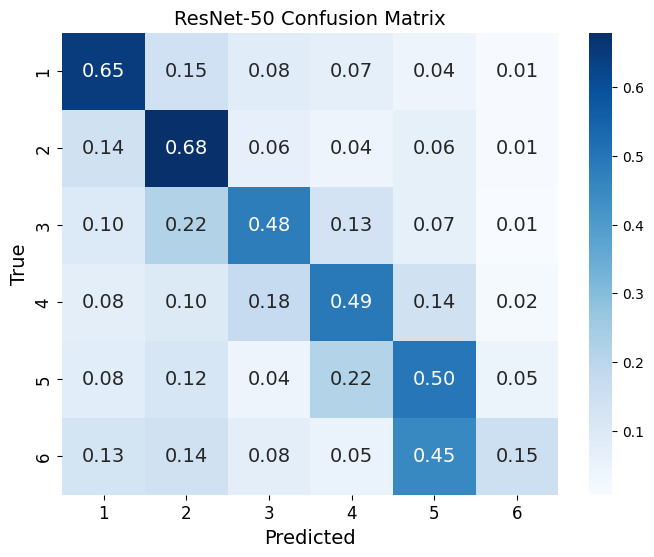

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=[1, 2, 3, 4, 5, 6], yticklabels=[1, 2, 3, 4, 5, 6], annot_kws={"size": 14})
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('ResNet-50 Confusion Matrix', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


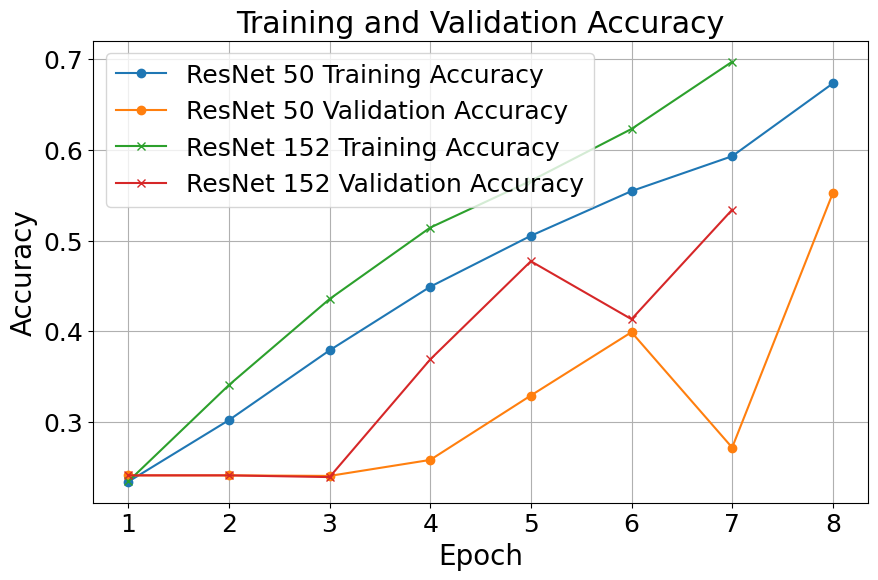

In [ ]:
import matplotlib.pyplot as plt
# Set the global font size
plt.rcParams['font.size'] = 18  # Adjust as needed
plt.rcParams['axes.labelsize'] = 20  # Adjust as needed for x and y labels
plt.rcParams['xtick.labelsize'] = 18  # Adjust as needed for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 18 # Adjust as needed for y-axis tick labels
plt.rcParams['legend.fontsize'] = 18 # Adjust as needed for legend
# Data for training and validation
epochs = list(range(1, 9))
resnet50_acc = [0.2345, 0.3023, 0.3791, 0.4491, 0.5052, 0.5544, 0.5928, 0.6729]
resnet50_val_acc = [0.2415, 0.2415, 0.2409, 0.2585, 0.3294, 0.3991, 0.2721, 0.5521]
resnet152_acc = [0.2348, 0.3409, 0.4356, 0.5142, 0.5657, 0.6228, 0.6968]
resnet152_val_acc = [0.2415, 0.2415, 0.2396, 0.3691, 0.4772, 0.4134, 0.5339]

plt.figure(figsize=(10, 6))

# Plotting ResNet 50 Accuracy and Validation Accuracy
plt.plot(epochs, resnet50_acc, label='ResNet 50 Training Accuracy', marker='o')
plt.plot(epochs, resnet50_val_acc, label='ResNet 50 Validation Accuracy', marker='o')

# Plotting ResNet 152 Accuracy and Validation Accuracy
plt.plot(epochs[:len(resnet152_acc)], resnet152_acc, label='ResNet 152 Training Accuracy', marker='x')
plt.plot(epochs[:len(resnet152_val_acc)], resnet152_val_acc, label='ResNet 152 Validation Accuracy', marker='x')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


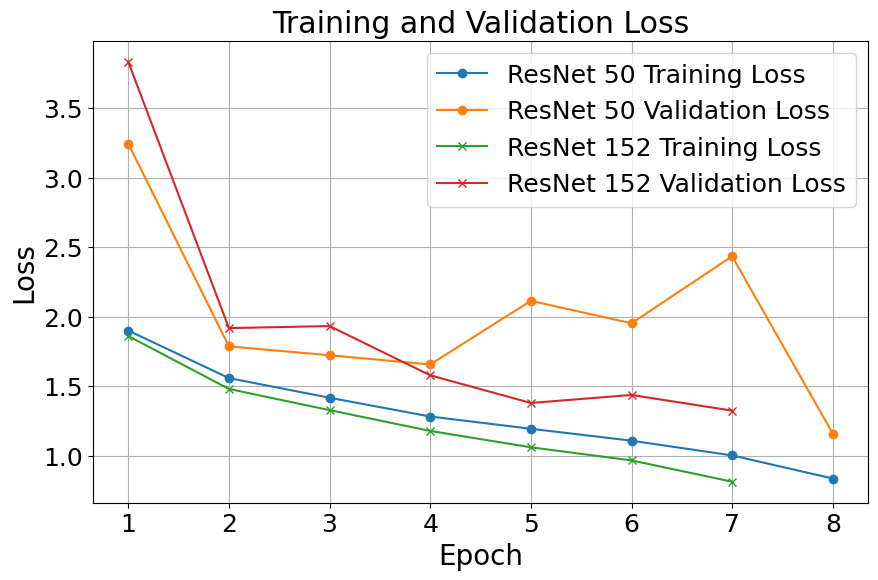

In [ ]:
epochs = list(range(1, 9))
# Data for training and validation loss
resnet50_loss = [1.9016, 1.5598, 1.4182, 1.2832, 1.1951, 1.1094, 1.0033, 0.8371]
resnet50_val_loss = [3.2466, 1.7877, 1.7240, 1.6575, 2.1154, 1.9539, 2.4360, 1.1603]
resnet152_loss = [1.8623, 1.4816, 1.3290, 1.1795, 1.0618, 0.9674, 0.8141]
resnet152_val_loss = [3.8356, 1.9192, 1.9339, 1.5799, 1.3806, 1.4382, 1.3255]

plt.figure(figsize=(10, 6))

# Plotting ResNet 50 Loss and Validation Loss
plt.plot(epochs, resnet50_loss, label='ResNet 50 Training Loss', marker='o')
plt.plot(epochs, resnet50_val_loss, label='ResNet 50 Validation Loss', marker='o')

# Plotting ResNet 152 Loss and Validation Loss
plt.plot(epochs[:len(resnet152_loss)], resnet152_loss, label='ResNet 152 Training Loss', marker='x')
plt.plot(epochs[:len(resnet152_val_loss)], resnet152_val_loss, label='ResNet 152 Validation Loss', marker='x')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
